In [7]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from tqdm.notebook import tqdm

from custom_image_dataset import CustomImageDataset

%matplotlib inline

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"We use: {device}")

We use: cuda


# I. Datasets and Dataloaders

#### Load dataset csv files as pd dataframes and print statistics

In [3]:
path_chest_imagenome_customized = "/u/home/tanida/datasets/chest-imagenome-dataset-customized-full"

# reduce memory usage by only using necessary columns and selecting appropriate datatypes
usecols = ["mimic_image_file_path", "bbox_name", "x1", "y1", "x2", "y2", "is_abnormal"]
dtype = {"x1": "int16", "x2": "int16", "y1": "int16", "y2": "int16", "bbox_name": "category"} 

datasets_as_dfs = {dataset: os.path.join(path_chest_imagenome_customized, dataset) + ".csv" for dataset in ["train", "valid", "test"]}
datasets_as_dfs = {dataset: pd.read_csv(csv_file_path, usecols=usecols, dtype=dtype) for dataset, csv_file_path in datasets_as_dfs.items()}

In [4]:
def print_num_samples_per_class(dataset, df):
    print(f"{dataset}:")
    for bbox_name, count in df["bbox_name"].value_counts().iteritems():
        print(f"\t{bbox_name}: {count}")
    print()

In [30]:
# get number of samples per class for each dataset

# bboxes of anatomical regions are almost distributed equally in all datasets,
# only a slight imbalance because not every image has bboxes of all 36 anatomical regions
for dataset, df in datasets_as_dfs.items():
    print_num_samples_per_class(dataset, df)

train:
	cardiac silhouette: 166490
	left lung: 166460
	mediastinum: 166456
	right lung: 166431
	spine: 166281
	trachea: 166280
	abdomen: 166276
	right upper abdomen: 166276
	left cardiac silhouette: 166272
	left upper abdomen: 166263
	upper mediastinum: 166260
	right upper lung zone: 166259
	right atrium: 166253
	left hemidiaphragm: 166237
	left upper lung zone: 166226
	right cardiac silhouette: 166214
	right hemidiaphragm: 166172
	right costophrenic angle: 166137
	cavoatrial junction: 166096
	right cardiophrenic angle: 166001
	left costophrenic angle: 165875
	svc: 165755
	left cardiophrenic angle: 165753
	descending aorta: 165705
	right clavicle: 165587
	left clavicle: 165442
	carina: 165188
	aortic arch: 164718
	right lower lung zone: 162983
	right mid lung zone: 162889
	right hilar structures: 162883
	right apical zone: 162836
	left lower lung zone: 162582
	left apical zone: 162386
	left hilar structures: 162170
	left mid lung zone: 162146

valid:
	cardiac silhouette: 23949
	right l

In [5]:
# get number of samples for each dataset
total_num_samples = sum(len(df) for df in datasets_as_dfs.values())

for dataset, df in datasets_as_dfs.items():
    print(f"{dataset}: {len(df):,} samples ({(len(df) / total_num_samples) * 100:.2f}%)")

train: 5,950,238 samples (70.00%)
valid: 855,467 samples (10.06%)
test: 1,694,389 samples (19.93%)


In [6]:
# if we don't want to train on the full train set (with 5,950,238 samples), we can specify the constant below to limit the train set

PERCENTAGE_OF_TRAIN_SET_TO_USE = 0.3
total_num_samples_train = len(datasets_as_dfs["train"])

new_num_samples_train = int(PERCENTAGE_OF_TRAIN_SET_TO_USE * total_num_samples_train)

datasets_as_dfs["train"] = datasets_as_dfs["train"][:new_num_samples_train]

print(f"train (new): {len(datasets_as_dfs['train']):,} samples")

train (new): 1,785,071 samples


#### Load datasets as Dataset objects

In [19]:
# constants for image transformations
mean=[0.485, 0.456, 0.406]
std=[0.229, 0.224, 0.225]

IMAGE_INPUT_SIZE = 224  # pre-trained DenseNet121 model expects images to be of size 224x224

In [20]:
# note: transforms are applied to the already cropped images (see __getitem__ method of CustomImageDataset class)!

train_transforms = transforms.Compose([
    # we want the long side of the image to be resized to IMAGE_INPUT_SIZE, and the short side of the image to be padded to IMAGE_INPUT_SIZE on both sides,
    # such that the aspect ratio of the images are kept (i.e. a resized image of a lung is not distorted)

    # we can achieve this by specifying size=IMAGE_INPUT_SIZE-1 and max_size=IMAGE_INPUT_SIZE in the Resize transformation
    # 
    transforms.Resize(size=IMAGE_INPUT_SIZE-1, max_size=IMAGE_INPUT_SIZE),  
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

# don't apply data augmentations to val and test set
val_test_transforms = transforms.Compose([
    transforms.Resize(size=IMAGE_INPUT_SIZE-1, max_size=IMAGE_INPUT_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [ ]:
train_dataset = CustomImageDataset(dataset_df=datasets_as_dfs["train"], transforms=train_transforms)
val_dataset = CustomImageDataset(dataset_df=datasets_as_dfs["vald"], transforms=val_test_transforms)
test_dataset = CustomImageDataset(dataset_df=datasets_as_dfs["test"], transforms=val_test_transforms)

In [9]:
from PIL import Image

<class 'PIL.Image.Image'>
(900, 1910)


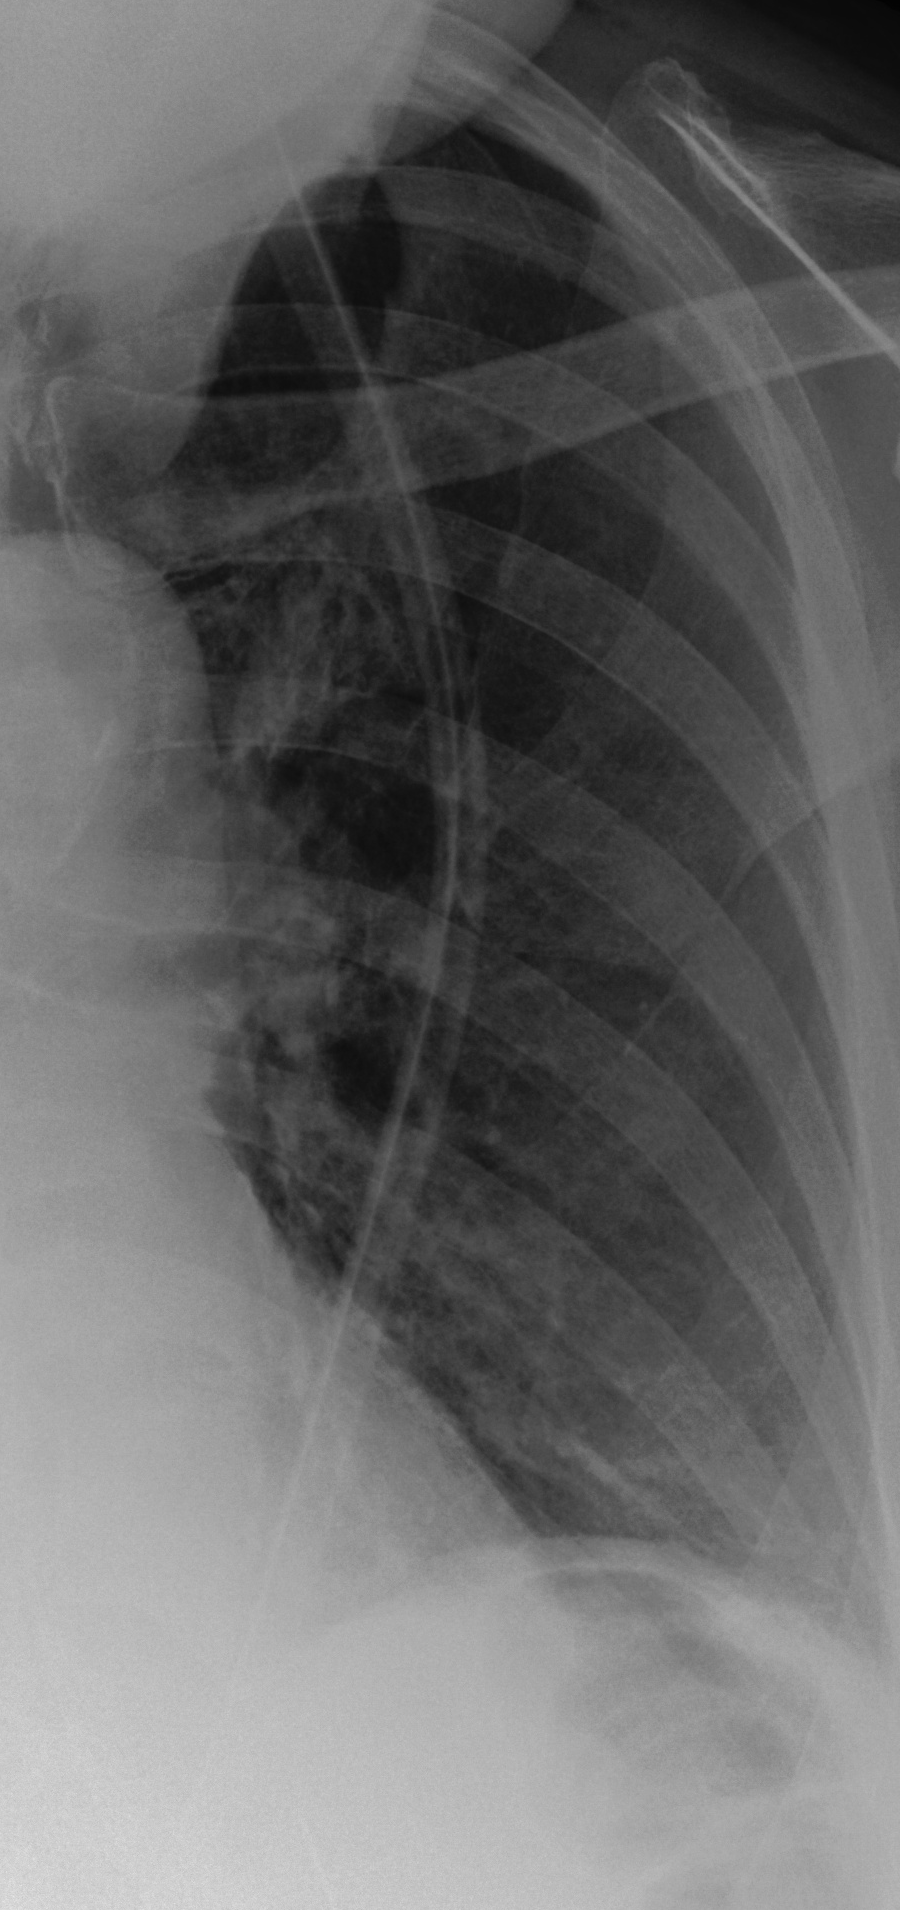

In [17]:
image_path = "/u/home/tanida/datasets/mimic-cxr-jpg/files/p10/p10001401/s50225296/0009a9fb-eb905e90-824cad7c-16d40468-007f0038.jpg"
image = Image.open(image_path)

bbox_coords = [1364, 341, 2264, 2251]
cropped_image = image.crop(box=bbox_coords)

print(type(cropped_image))
print(cropped_image.size)
display(cropped_image)

In [18]:
resized_cropped_image = transforms.functional.resize(cropped_image, size=224, max_size=224)
print(resized_cropped_image)
display(resized_cropped_image)

ValueError: max_size = 224 must be strictly greater than the requested size for the smaller edge size = 224

In [23]:
val_test_transforms

Compose(
    Resize(size=223, interpolation=bilinear, max_size=224, antialias=None)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [24]:
val_test_transforms[1:]

TypeError: 'Compose' object is not subscriptable

In [15]:
# specify path to folder where model weights should be saved
model_save_path = "/u/home/tanida/weights/encoder"